In [1]:
import datetime
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

csv_file_name = 'cleaned_whole_df.csv'
df = pd.read_csv(csv_file_name, dtype={'Company Size': str}, skiprows=lambda x: x % 2)

hot_encode_columns = [
    'Lead Job Title',
    'Company Size',
    'Company Industry',
    'Company Li Company Type',
    'Company Location Country Name',
    'Email Status'
]

df_encoded = pd.DataFrame()

current_year = datetime.datetime.now().year
df_encoded['Years Since Company Founded'] = current_year - df['Company Founded In']

# Convert Lead Years and Months to total months for position
df_encoded['Total Months In Position'] = df['Lead Years In Position'] * 12 + df['Lead Months In Position']

# Convert Lead Years and Months to total months for company tenure
df_encoded['Total Months In Company'] = df['Lead Years In Company'] * 12 + df['Lead Months In Company']

for column in hot_encode_columns+['Relevant', 'Company Followers', 'Company Des Relevant Score']:
    df_encoded[column] = df[column]
    
df_encoded = pd.get_dummies(df_encoded, columns=hot_encode_columns)

df_encoded.fillna(0, inplace=True)


df_encoded['Relevant'] = df_encoded['Relevant'].replace(2, 1)

In [2]:
df_encoded.to_csv("Consolidated_3_datasets_3_29.csv", index=False)

In [3]:
import datetime
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


# Define features (X) and target variable (y)
X = df_encoded.drop(columns=['Relevant'])
y = df_encoded['Relevant']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance using upsampling of minority class (1)
X_train_balanced, y_train_balanced = resample(X_train[y_train == 1],
                                              y_train[y_train == 1],
                                              replace=True,
                                              n_samples=sum(y_train == 0),
                                              random_state=39)

X_train_balanced = pd.concat([X_train[y_train == 0], X_train_balanced])
y_train_balanced = pd.concat([y_train[y_train == 0], y_train_balanced])


In [4]:
# Initialize the XGBoost classifier
xgb_classifier = XGBClassifier(
    scale_pos_weight= 700,
    subsample= 0.8066517299982808,
    colsample_bytree= 0.9050700505156465,
    min_child_weight= 1.2000874293433028,
    max_depth= 10,
    alpha= 0.04563770833926443,
    gamma= 4.862852895053753e-08,
)

# Train the classifier on the balanced dataset
xgb_classifier.fit(X_train_balanced, y_train_balanced)

y_pred = xgb_classifier.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9342105263157895

Confusion Matrix:
 [[340  17]
 [  8  15]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.95      0.96       357
         1.0       0.47      0.65      0.55        23

    accuracy                           0.93       380
   macro avg       0.72      0.80      0.75       380
weighted avg       0.95      0.93      0.94       380



In [5]:
import optuna
import xgboost as xgb
import numpy as np
import sklearn.metrics

def objective(trial):
    dtrain = xgb.DMatrix(X_train_balanced, label = y_train_balanced)
    dvalid = xgb.DMatrix(X_test, label = y_test)
    
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "tree_method": "exact",
        "booster": "gbtree",  # Fixed to gbtree based on the original implementation
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 10, 1000.0),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "min_child_weight":trial.suggest_float("min_child_weight", 0.1, 10.0),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),        
    }

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    
    # Converting probabilities to binary predictions based on threshold 0.5
    pred_labels = (preds >= 0.5).astype(int)
    
    # Calculate precision for class 1
    precision = sklearn.metrics.precision_score(y_test, pred_labels, pos_label=1)
    return precision

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, timeout=600)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-03-29 01:26:01,851] A new study created in memory with name: no-name-279d5036-8a66-4e24-b477-01eeac26f699
[I 2024-03-29 01:26:03,835] Trial 0 finished with value: 0.15862068965517243 and parameters: {'scale_pos_weight': 841.151294345585, 'subsample': 0.5080702526427983, 'colsample_bytree': 0.4863248717073755, 'min_child_weight': 5.050884117647868, 'max_depth': 6, 'lambda': 0.06679155566520739, 'alpha': 1.5019982372940064e-07, 'gamma': 1.8529248836311724e-07}. Best is trial 0 with value: 0.15862068965517243.
[I 2024-03-29 01:26:05,202] Trial 1 finished with value: 0.16312056737588654 and parameters: {'scale_pos_weight': 375.816356248329, 'subsample': 0.9479719694527688, 'colsample_bytree': 0.2953114362541605, 'min_child_weight': 4.140561834442235, 'max_depth': 8, 'lambda': 0.02357331092840741, 'alpha': 8.220378277315575e-06, 'gamma': 3.0327795013246485e-05}. Best is trial 1 with value: 0.16312056737588654.
[I 2024-03-29 01:26:06,062] Trial 2 finished with value: 0.10132158590308

KeyboardInterrupt: 

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix

X_train_balanced_numeric = X_train_balanced.apply(pd.to_numeric, errors='coerce')
X_train_balanced_numeric.dropna(inplace=True)
X_train_array = X_train_balanced_numeric.values.astype(np.float32)

X_train_tensor = torch.tensor(X_train_array)
y_train_tensor = torch.tensor(y_train_balanced.values, dtype=torch.int64)

X_test_numeric = X_test.apply(pd.to_numeric, errors='coerce')
X_test_numeric.fillna(0, inplace=True)
X_test_array = X_test_numeric.values.astype(np.float32)

X_test_tensor = torch.tensor(X_test_array)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.int64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(X_train_balanced.shape[1], 16)
        self.layer2 = nn.Linear(16, 16)
        self.layer3 = nn.Linear(16, 16)
        self.layer4 = nn.Linear(16, 16)
        self.layer5 = nn.Linear(16, 16)
        self.layer6 = nn.Linear(16, 16)
        self.layer7 = nn.Linear(16, 16)
        self.output_layer = nn.Linear(16, 2)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        x = self.relu(self.layer5(x))
        x = self.relu(self.layer6(x))
        x = self.relu(self.layer7(x))
        x = self.softmax(self.output_layer(x))
        return x

model = NeuralNetwork()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

for epoch in range(200):
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}/150, Loss: {loss.item():.4f}')

with torch.no_grad():
    output = model(X_test_tensor)
    _, y_pred = torch.max(output, 1)

y_pred_numpy = y_pred.numpy()

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_numpy)
print("Confusion Matrix:\n", conf_matrix)

# Calculate classification report
class_report = classification_report(y_test, y_pred_numpy)
print("Classification Report:\n", class_report)

Epoch 1/150, Loss: 0.6896
Epoch 2/150, Loss: 0.6801
Epoch 3/150, Loss: 0.6793
Epoch 4/150, Loss: 0.6790
Epoch 5/150, Loss: 0.6788
Epoch 6/150, Loss: 0.6785
Epoch 7/150, Loss: 0.6780
Epoch 8/150, Loss: 0.6775
Epoch 9/150, Loss: 0.6771
Epoch 10/150, Loss: 0.6769
Epoch 11/150, Loss: 0.6766
Epoch 12/150, Loss: 0.6762
Epoch 13/150, Loss: 0.6759
Epoch 14/150, Loss: 0.6757
Epoch 15/150, Loss: 0.6754
Epoch 16/150, Loss: 0.6750
Epoch 17/150, Loss: 0.6746
Epoch 18/150, Loss: 0.6743
Epoch 19/150, Loss: 0.6740
Epoch 20/150, Loss: 0.6736
Epoch 21/150, Loss: 0.6732
Epoch 22/150, Loss: 0.6728
Epoch 23/150, Loss: 0.6725
Epoch 24/150, Loss: 0.6721
Epoch 25/150, Loss: 0.6716
Epoch 26/150, Loss: 0.6712
Epoch 27/150, Loss: 0.6707
Epoch 28/150, Loss: 0.6703
Epoch 29/150, Loss: 0.6697
Epoch 30/150, Loss: 0.6692
Epoch 31/150, Loss: 0.6687
Epoch 32/150, Loss: 0.6681
Epoch 33/150, Loss: 0.6675
Epoch 34/150, Loss: 0.6668
Epoch 35/150, Loss: 0.6661
Epoch 36/150, Loss: 0.6654
Epoch 37/150, Loss: 0.6646
Epoch 38/1

Epoch 1/400, Training Loss: 0.5708, Validation Loss: 0.6046
Epoch 2/400, Training Loss: 0.5680, Validation Loss: 0.6444
Epoch 3/400, Training Loss: 0.5785, Validation Loss: 0.5839
Epoch 4/400, Training Loss: 0.5694, Validation Loss: 0.5630
Epoch 5/400, Training Loss: 0.5710, Validation Loss: 0.5492
Epoch 6/400, Training Loss: 0.5720, Validation Loss: 0.5389
Epoch 7/400, Training Loss: 0.5731, Validation Loss: 0.5295
Epoch 8/400, Training Loss: 0.5741, Validation Loss: 0.5230
Epoch 9/400, Training Loss: 0.5748, Validation Loss: 0.5181
Epoch 10/400, Training Loss: 0.5754, Validation Loss: 0.5153
Epoch 11/400, Training Loss: 0.5763, Validation Loss: 0.5145
Epoch 12/400, Training Loss: 0.5760, Validation Loss: 0.5155
Epoch 13/400, Training Loss: 0.5753, Validation Loss: 0.5174
Epoch 14/400, Training Loss: 0.5748, Validation Loss: 0.5197
Epoch 15/400, Training Loss: 0.5739, Validation Loss: 0.5223
Epoch 16/400, Training Loss: 0.5726, Validation Loss: 0.5255
Epoch 17/400, Training Loss: 0.57

Epoch 137/400, Training Loss: 0.5577, Validation Loss: 0.5370
Epoch 138/400, Training Loss: 0.5541, Validation Loss: 0.5466
Epoch 139/400, Training Loss: 0.5509, Validation Loss: 0.5567
Epoch 140/400, Training Loss: 0.5483, Validation Loss: 0.5665
Epoch 141/400, Training Loss: 0.5465, Validation Loss: 0.5758
Epoch 142/400, Training Loss: 0.5455, Validation Loss: 0.5839
Epoch 143/400, Training Loss: 0.5454, Validation Loss: 0.5911
Epoch 144/400, Training Loss: 0.5458, Validation Loss: 0.5977
Epoch 145/400, Training Loss: 0.5460, Validation Loss: 0.6034
Epoch 146/400, Training Loss: 0.5458, Validation Loss: 0.6074
Epoch 147/400, Training Loss: 0.5451, Validation Loss: 0.6102
Epoch 148/400, Training Loss: 0.5439, Validation Loss: 0.6137
Epoch 149/400, Training Loss: 0.5417, Validation Loss: 0.6202
Epoch 150/400, Training Loss: 0.5399, Validation Loss: 0.6272
Epoch 151/400, Training Loss: 0.5394, Validation Loss: 0.6217
Epoch 152/400, Training Loss: 0.5374, Validation Loss: 0.6140
Epoch 15

Epoch 278/400, Training Loss: 0.6889, Validation Loss: 0.3978
Epoch 279/400, Training Loss: 0.6887, Validation Loss: 0.3973
Epoch 280/400, Training Loss: 0.6883, Validation Loss: 0.3974
Epoch 281/400, Training Loss: 0.6875, Validation Loss: 0.3980
Epoch 282/400, Training Loss: 0.6867, Validation Loss: 0.3986
Epoch 283/400, Training Loss: 0.6860, Validation Loss: 0.3992
Epoch 284/400, Training Loss: 0.6854, Validation Loss: 0.3995
Epoch 285/400, Training Loss: 0.6849, Validation Loss: 0.3996
Epoch 286/400, Training Loss: 0.6844, Validation Loss: 0.3994
Epoch 287/400, Training Loss: 0.6838, Validation Loss: 0.3990
Epoch 288/400, Training Loss: 0.6832, Validation Loss: 0.3984
Epoch 289/400, Training Loss: 0.6825, Validation Loss: 0.3978
Epoch 290/400, Training Loss: 0.6818, Validation Loss: 0.3972
Epoch 291/400, Training Loss: 0.6810, Validation Loss: 0.3961
Epoch 292/400, Training Loss: 0.6803, Validation Loss: 0.3949
Epoch 293/400, Training Loss: 0.6800, Validation Loss: 0.3946
Epoch 29

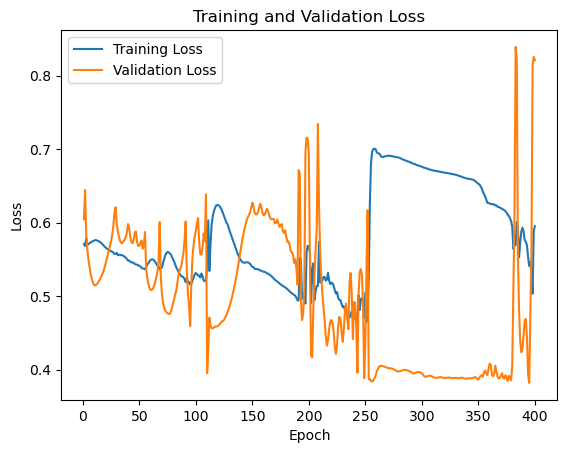

In [7]:
import matplotlib.pyplot as plt

# Lists to store training and validation loss
train_losses = []
val_losses = []

# Training loop
for epoch in range(400):
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    # Calculate validation loss
    with torch.no_grad():
        output = model(X_test_tensor)
        val_loss = criterion(output, y_test_tensor)
        val_losses.append(val_loss.item())
    
    print(f'Epoch {epoch+1}/400, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

# Plot training and validation loss
plt.plot(range(1, 401), train_losses, label='Training Loss')
plt.plot(range(1, 401), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()